In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

### rnn

In [1]:
import numpy as np
import os
data_index = 2
dataset_path = f"../../dataset/dataset_0725/p{data_index}"
saveModel_dir = f'../../savedModel/p{data_index}_processed'
os.makedirs(saveModel_dir, exist_ok=True)
results_dir = f'../../saveResult/p{data_index}_processed'
os.makedirs(results_dir, exist_ok=True)
saveplot_dir = f'../../savePlot/p{data_index}_processed'
os.makedirs(saveplot_dir, exist_ok=True)


X_train = np.load(f'{dataset_path}/X_train.npy')
y_train = np.load(f'{dataset_path}/y_train.npy').astype(float).flatten()
X_val = np.load(f'{dataset_path}/X_val.npy')
y_val = np.load(f'{dataset_path}/y_val.npy').astype(float).flatten()
X_test = np.load(f'{dataset_path}/X_test.npy')
y_test = np.load(f'{dataset_path}/y_test.npy').astype(float).flatten()


X_train.shape



(4345, 12)

# with lr list

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义 RNN 回归模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.1):
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy

# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
learning_rates = [ 1e-2, 1e-3, 1e-4, 1e-5]
num_epochs = 1000

results = {}


Training with learning rate: 0.01


Learning Rate 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Learning Rate 0.01: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Training with learning rate: 0.001


Learning Rate 0.001: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]


Training with learning rate: 0.0001


Learning Rate 0.0001: 100%|██████████| 1000/1000 [06:29<00:00,  2.56it/s]


Training with learning rate: 1e-05


Learning Rate 1e-05: 100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


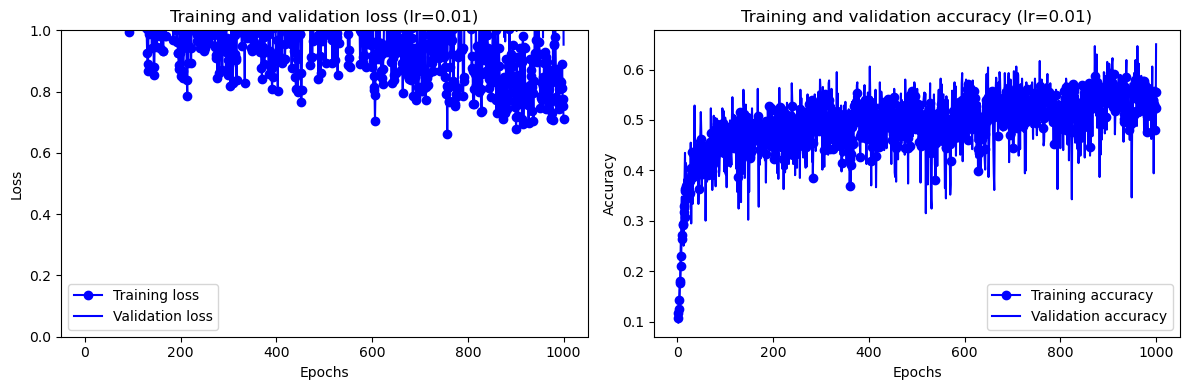

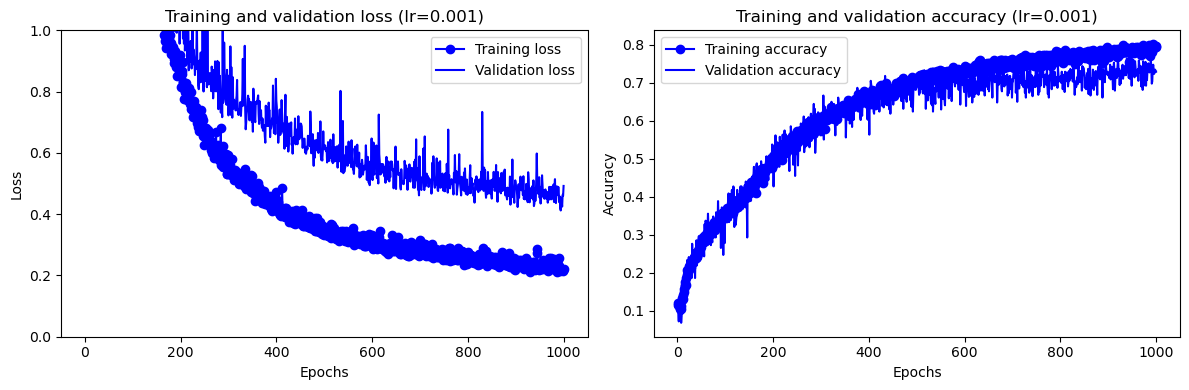

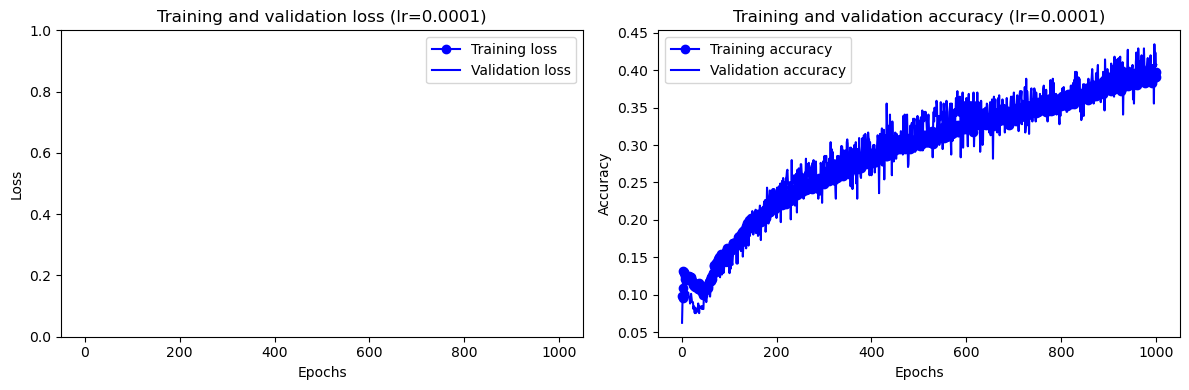

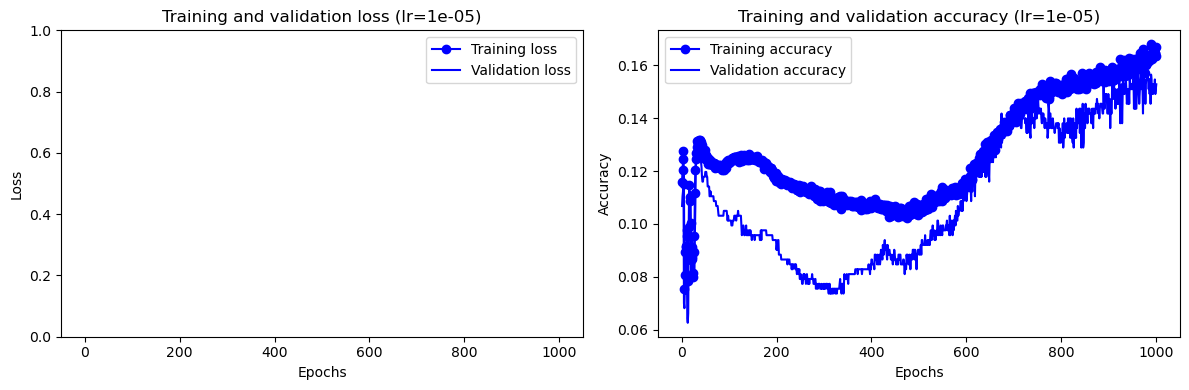

Results saved to ../../saveResult/p2_processed/training_results.txt
Learning rate: 0.01
Best Validation Accuracy: 0.6501 at epoch 1000
Lowest Validation Loss: 0.9254 at epoch 757
Best Training Accuracy: 0.5922 at epoch 904
Lowest Training Loss: 0.6613 at epoch 757


Learning rate: 0.001
Best Validation Accuracy: 0.7643 at epoch 939
Lowest Validation Loss: 0.4121 at epoch 994
Best Training Accuracy: 0.8016 at epoch 994
Lowest Training Loss: 0.2125 at epoch 930


Learning rate: 0.0001
Best Validation Accuracy: 0.4346 at epoch 996
Lowest Validation Loss: 1.2707 at epoch 996
Best Training Accuracy: 0.4023 at epoch 985
Lowest Training Loss: 1.1965 at epoch 997


Learning rate: 1e-05
Best Validation Accuracy: 0.1584 at epoch 956
Lowest Validation Loss: 4.0740 at epoch 1000
Best Training Accuracy: 0.1680 at epoch 989
Lowest Training Loss: 4.4388 at epoch 1000




In [4]:
import os

# 定义保存模型的目录



# 定义保存模型的函数
def save_checkpoint(model, optimizer, epoch, val_accuracy, val_loss, file_path):
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_accuracy,
        'val_loss': val_loss
    }
    torch.save(checkpoint, file_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = RNNModel(input_dim=12, hidden_dim=128, output_dim=1, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    lowest_val_loss = float('inf')
    lowest_val_loss_epoch = 0
    best_train_accuracy = 0.0
    best_train_accuracy_epoch = 0
    lowest_train_loss = float('inf')
    lowest_train_loss_epoch = 0
    train_output_result = []
    train_true_result = []
    val_output_result = []
    val_true_result = []
    for epoch in tqdm(range(num_epochs), desc=f"Learning Rate {lr}"):
        model.train()
        running_loss = 0.0
        all_predictions_train = []
        all_labels_train = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            all_predictions_train.append(outputs)
            all_labels_train.append(labels.unsqueeze(1))
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        all_predictions_train = torch.cat(all_predictions_train, dim=0)
        all_labels_train = torch.cat(all_labels_train, dim=0)

        train_output_result.append(all_predictions_train)
        train_true_result.append(all_labels_train)

        train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=0.5)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
                val_loss += loss.item() * inputs.size(0)
                
                all_predictions.append(outputs)
                all_labels.append(labels.unsqueeze(1))
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        val_output_result.append(all_predictions)
        val_true_result.append(all_labels)

        val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.5)
        val_accuracies.append(val_accuracy)
        
        # 记录最好的准确率和最低的损失
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_accuracy_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, val_accuracy, val_loss, os.path.join(saveModel_dir, f"best_val_accuracy_lr_{lr}.pt"))
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            lowest_val_loss_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, val_accuracy, val_loss, os.path.join(saveModel_dir, f"lowest_val_loss_lr_{lr}.pt"))
        
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_accuracy_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, train_accuracy, epoch_loss, os.path.join(saveModel_dir, f"best_train_accuracy_lr_{lr}.pt"))
        
        if epoch_loss < lowest_train_loss:
            lowest_train_loss = epoch_loss
            lowest_train_loss_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, train_accuracy, epoch_loss, os.path.join(saveModel_dir, f"lowest_train_loss_lr_{lr}.pt"))

    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch,
        'lowest_val_loss': lowest_val_loss,
        'lowest_val_loss_epoch': lowest_val_loss_epoch,
        'best_train_accuracy': best_train_accuracy,
        'best_train_accuracy_epoch': best_train_accuracy_epoch,
        'lowest_train_loss': lowest_train_loss,
        'lowest_train_loss_epoch': lowest_train_loss_epoch,
        'train_output_result': train_output_result,
        'train_true_result': train_true_result,
        'val_output_result': val_output_result,
        'val_true_result': val_true_result
    }

    import os

# 创建保存图片的目录


# 绘制图表
for lr, result in results.items():
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result['train_losses'], 'bo-', label='Training loss')
    plt.plot(epochs, result['val_losses'], 'b-', label='Validation loss')
    plt.title(f'Training and validation loss (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, result['train_accuracies'], 'bo-', label='Training accuracy')
    plt.plot(epochs, result['val_accuracies'], 'b-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
    # 保存图片
    plot_filename = os.path.join(saveplot_dir, f'training_validation_lr_{lr}.png')
    plt.savefig(plot_filename)
    
    # 显示图片
    plt.show()
# 定义保存文件的路径
results_file = 'training_results.txt'

os.makedirs(results_dir, exist_ok=True)
# 打开文件写入模式
with open(f'{results_dir}/{results_file}', 'w') as f:
    for lr, result in results.items():
        f.write(f"Learning rate: {lr}\n")
        f.write(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}\n")
        f.write(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}\n")
        f.write(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}\n")
        f.write(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}\n")
        f.write("\n")

print(f"Results saved to {results_dir}/{results_file}")

for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}")
    print(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}")
    print(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}")
    print(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}")
    print("\n")
